In [1]:
import fibre
import odrive
import odrive.enums as oe
from odrive.utils import start_liveplotter, dump_errors

import numpy as np
import matplotlib.pyplot as plt
import time

FULL_CALIBRATION_SEQUENCE = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
CLOSED_LOOP_CONTROL = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
IDLE = odrive.enums.AXIS_STATE_IDLE
CURRENT_CONTROL = odrive.enums.CTRL_MODE_CURRENT_CONTROL
VELOCITY_CONTROL = odrive.enums.CTRL_MODE_VELOCITY_CONTROL
POSITION_CONTROL = odrive.enums.CTRL_MODE_POSITION_CONTROL

%matplotlib notebook

## Setup Plots

In [3]:
def plot_controller_state(time_resolution=0.1, duration=5):

    fig,(ax, vel_ax, current_ax) = plt.subplots(3)
    plt.ion()

    fig.suptitle('Setpoint vs Estimate plots')
    fig.show()
    fig.canvas.draw()
    
    t = np.array([])
    
    pos_estimates = np.array([])
    pos_setpoints = np.array([])
    
    vel_estimates = np.array([])
    vel_setpoints = np.array([]) 
    
    current_setpoints = np.array([])
    current_measurements = np.array([])
    
    plot_duration = duration
    delta_t = time_resolution
    
    for i in range(0,(int)(plot_duration/delta_t)):
        ax.clear()
        current_ax.clear()
        vel_ax.clear()
        
        t = np.append(t, [i * delta_t])
        
        # Update position plot
        pos_estimates = np.append(pos_estimates, [encoder.pos_estimate])
        pos_setpoints = np.append(pos_setpoints, [controller.pos_setpoint])
    
        ax.plot(t, pos_setpoints, label='Position Setpoint')
        ax.plot(t, pos_estimates, label='Position Estimate')
        ax.legend()
        
        # Update velocity plot
        vel_estimates = np.append(vel_estimates, [encoder.vel_estimate])
        vel_setpoints = np.append(vel_setpoints, [controller.vel_setpoint])
    
        vel_ax.plot(t, vel_setpoints, label='Velocity Setpoint')
        vel_ax.plot(t, vel_estimates, label='Velocity Estimate')
        vel_ax.legend()
        
        # Update current plot
        current_setpoints = np.append(current_setpoints, [motor.current_control.Iq_setpoint])
        current_measurements = np.append(current_measurements, [motor.current_control.Iq_measured])

        current_ax.plot(t, current_setpoints, label="Current Setpoint")
        current_ax.plot(t, current_measurements, label="Current Measurement")
        current_ax.legend()
        
        fig.canvas.draw()
        time.sleep(delta_t)
        
#plot_controller_state(duration=3)

## Connect odrive

In [4]:
try:
    odrv.reboot()
except:
    pass

try:
    odrv = odrive.find_any(timeout=30)
    print('Connected to odrive!')
    axis = odrv.axis0
    controller = axis.controller
    motor = axis.motor
    encoder = axis.encoder
except TimeoutError as ex:
    print('No odrive found!')
    

Connected to odrive!


## Configure

In [5]:
# Calibration based on https://docs.odriverobotics.com/hoverboard
odrv.config.dc_bus_overvoltage_trip_level = 29.0

# https://www.uumotor.com/high-torque-500-1000w-servo-hub-motor.html
motor.config.pole_pairs = 20 # 10 according to webiste, possibly 20?
motor.config.current_lim = 40.0
motor.config.resistance_calib_max_voltage = 4
motor.config.requested_current_range = 25 # Requires save and reboot
motor.config.current_control_bandwidth = 100

encoder.config.cpr = 4 * 1024 # 1024pps according to website, possibly 512?
encoder.config.bandwidth = 500.0 # Default

controller.config.pos_gain = 1
controller.config.vel_gain = 0.02
controller.config.vel_integrator_gain = 0.1
controller.config.vel_limit = 50000

## Calibrate

In [6]:
axis.requested_state = FULL_CALIBRATION_SEQUENCE

## Test

### Test position step

<IPython.core.display.Javascript object>


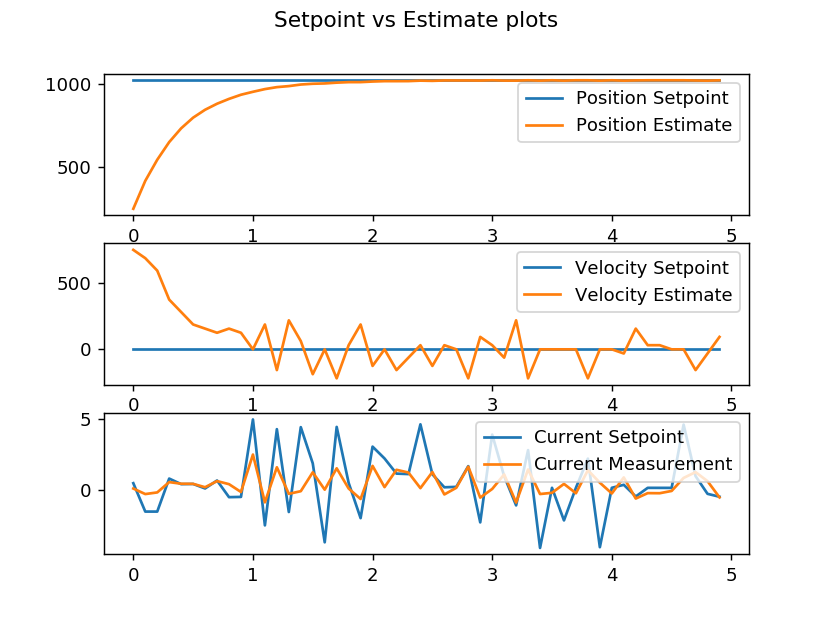

In [7]:
%matplotlib notebook
controller.config.control_mode = POSITION_CONTROL
axis.requested_state = CLOSED_LOOP_CONTROL
controller.pos_setpoint = encoder.pos_estimate + 1000

plot_controller_state(duration=5.0)


### Test constant velocity

<IPython.core.display.Javascript object>


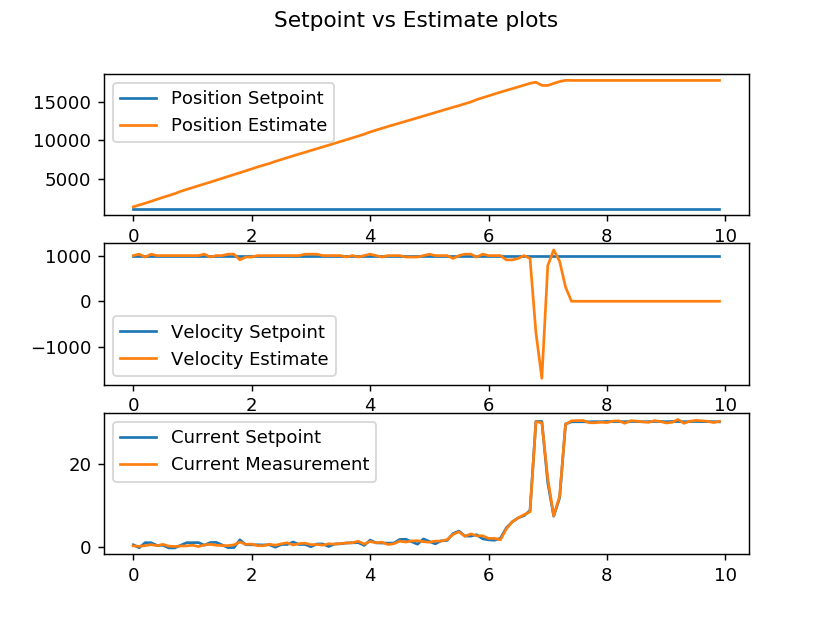

In [8]:
%matplotlib notebook
controller.config.control_mode = VELOCITY_CONTROL
axis.requested_state = CLOSED_LOOP_CONTROL
controller.vel_setpoint = 1000

plot_controller_state(duration=10.0)

### Test constant current

<IPython.core.display.Javascript object>


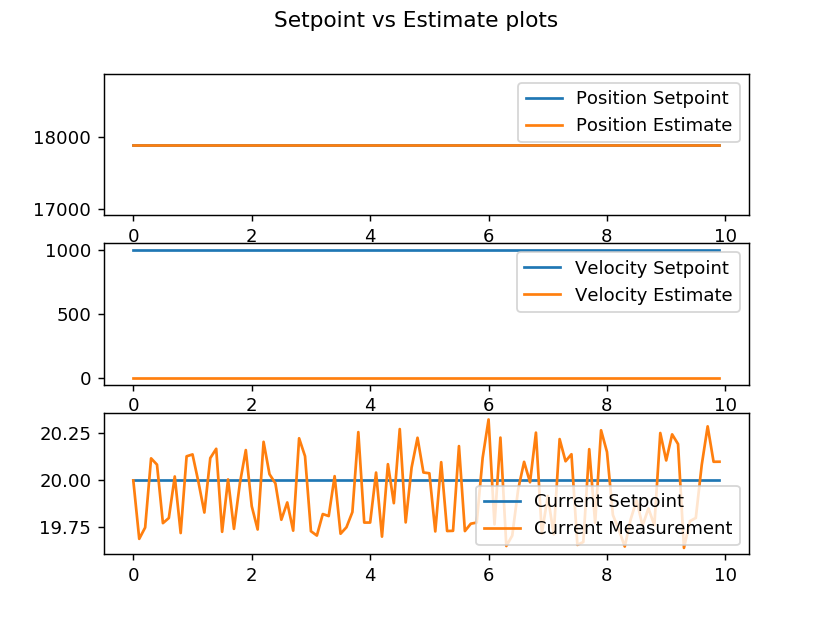

In [9]:
%matplotlib notebook
controller.config.control_mode = CURRENT_CONTROL
axis.requested_state = CLOSED_LOOP_CONTROL
controller.current_setpoint = 20.0

plot_controller_state(duration=10.0)

## Stop, dump errors and clear errors

In [10]:
axis.requested_state = IDLE
dump_errors(odrv)
axis.error = 0
encoder.error = 0
motor.error = 0

axis0
  axis: no error
  motor: no error
  encoder: no error
  controller: no error
axis1
  axis: no error
  motor: no error
  encoder: no error
  controller: no error


In [ ]:
encoder.config.cpr


## Save

In [63]:
odrv.save_configuration()
odrv.reboot()

ChannelBrokenException: 

## Reset config

In [ ]:
odrv.erase_configuration()
odrv.reboot()